# CONNECT TO API AND GET DATA

In [1]:
import requests
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as dt

datafolder = 'workdata'

In [3]:
def getCountriesTable():
    """
        get the list of country available
        useful to build country list for further requests
    """
    url = "https://api.covid19api.com/countries"
    payload = {}
    headers= {}
    response = requests.request("GET", url, headers=headers, data = payload)
    
    df=pd.DataFrame(response.json())
    df.to_csv(datafolder+'/countriesNameTable.csv')

getCountriesTable()

def getPandaFrameForCountry(CountryName):
    """
        return full data off covid19api for input CountryName
        JSON format to transform in dataframe
    """
    url = "https://api.covid19api.com/total/country/"+CountryName
    payload = {}
    headers= {}
    response = requests.request("GET", url, headers=headers, data = payload)
    return response.json()

def correctDateOnPandaFrame(pddf):
    """
        correct the specific date column format in covid19 api results
        2020-01-22T00:00:00Z
    """
    for i,elem in pddf.iterrows():
        splitdate = elem['Date'].split('T')
        newdate = datetime.strptime(splitdate[0], "%Y-%m-%d").date()
        pddf.at[i,'Date'] = newdate
        
def refresh_rawcsvfromAPI(payslist,datafolder,columnkeeplist):
    """
        get latest data from country list and replace RAW file
        
        DEPENDENCIES : getPandaFrameForCountry, correctDateOnPandaFrame
    """
    for paysname in payslist:
        rawdf=pd.DataFrame(getPandaFrameForCountry(paysname))
        # drop useless column
        rawdf.drop(rawdf.columns.difference(columnkeeplist), axis=1,inplace=True)
        # correct date
        correctDateOnPandaFrame(rawdf)
        # write csv with raw files
        filepath = datafolder+'/raw_'+paysname+'_ALLTable.csv'
        rawdf.to_csv(filepath,index=False)

## Variables

In [6]:
# If True : use the API to get the last values and rewrite csv
# else : will read rawCSV in archive (workdata)
REFRESH_CSV = False

# What to get and what to keep
payslist = ['France','Germany','Italy','Spain','Belgium','United Kingdom']
#payslist = ['France']#,'Germany','Italy','Spain','Belgium','United Kingdom']
columnkeeplist = ['Confirmed','Deaths','Recovered','Active','Date']
datacolumnlist = ['Confirmed','Deaths','Recovered','Active']

paysdf = {}

In [7]:
# GET WRITE / LOAD EXECUTION 
# get raw data and write it down in csv format
if REFRESH_CSV : refresh_rawcsvfromAPI(payslist,datafolder,columnkeeplist)

# LOAD countries data from CSV files 
for paysname in payslist:
    filepath = datafolder+'/raw_'+paysname+'_ALLTable.csv'
    paysdf[paysname] = pd.read_csv(filepath)

In [8]:
# VISUALISATION OF RAW DATAFRAMES

def plotcountry(countryval): 
    countryname = payslist[countryval]
    # Create figure and plot space
    currentdf = paysdf[countryname]

    fig, ax = plt.subplots(figsize=(12, 12))


    # !!!! MAKE SURE YOUR DATETIME IS CONSIDERED AS SUCH BY PANDAS !!!!!
    currentdf['Date'] = pd.to_datetime(currentdf['Date'])

    # Add x-axis and y-axis
    for colname in datacolumnlist :
        ax.plot(currentdf['Date'],
               currentdf[colname])
    # Set title and labels for axes
    ax.set(xlabel="Date",
           ylabel="Count",
           title="Daily cumulative total number in "+countryname)

    #ax.set_xlim(currentdf['Date'][0], currentdf['Date'][currentdf.shape[0]-1])
    ax.set_yscale('log')
    ax.set_ylim(bottom=100)
    ax.grid(True)

    # Define the date format
    #ax.xaxis.set_major_formatter(dt.DateFormatter('%m-%d'))  


    # Ensure a major tick (interval=1) 
    ax.xaxis.set_major_locator(dt.MonthLocator())
    #ax.xaxis.set_major_locator(dt.WeekdayLocator(interval=1))

    plt.show()

# DEFINE A SLIDER WIDGET TO CREATE AN INTERACTIVE PLOT
from IPython import display
from ipywidgets import interact, widgets
interact(plotcountry,countryval=widgets.IntSlider(min=0,max=len(payslist)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='countryval', max=5), Output()), _dom_classes=('widget-in…

<function __main__.plotcountry(countryval)>

## DEFINITION OF INCIDENCE ( number of new cases per day )

In [9]:
import math

def buildbrutIncidence(rawData,columnName):
    """
        Epidemic incidence calculation : substract valueT-1 to ValueT of a column, 
        nullify aberations (<0) and return a pandas.Series 
    """
    newdf = rawData[[columnName]]
    newdf['shift'] = newdf[columnName].shift(periods=1,fill_value=0)
    newdf['delta'] = newdf[columnName]-newdf['shift']
    #ZEROING negative values
    newdf['delta'] = newdf['delta'].apply(lambda x: 0 if x < 0 else x)
    return newdf['delta']
    
def indicateurMM(rawData,columnName,nbfactor=2):
    """
        based on moving average calculation : get T-nbfactor lasts values from T and get a mean
        (firsts values are approximations on available values)
        return a pandas.Series
    """
    newdf = rawData[[columnName]]
    #print(newdf.shape[0])
    listval = []
    #Loop Values
    for i in range(0,newdf.shape[0]):
        curval = 0
        if i < nbfactor:
            curval = pd.Series([newdf[columnName][j] for j in range(0,i+1)]).mean()
        else :
            curval = pd.Series([newdf[columnName][j] for j in range(i-nbfactor+1,i+1)]).mean()     
        listval.append(round(curval,1))
    return pd.Series(listval)

def indicateurExpMM(rawData,columnName,alpha=0.1):
    """
        based on exponential moving average calculation : 
        get sum of T-nvalue * ( a(1-a)^n )
        return a pandas.Series
    """    
    newdf = rawData[[columnName]]
    #print(newdf.shape[0])
    listval = []
    #Loop Values with sum alpha(1-alpha)^n * Xn
    for i in range(0,newdf.shape[0]):
        curval = 0
        curval = pd.Series([newdf[columnName][j]*(alpha*math.pow((1-alpha),i-j)) 
                                for j in range(0,i+1)]).sum()   
        listval.append(round(curval,2))
        #print(i,round(curval,2))
    return pd.Series(listval)

def TEST_indicateurExpMM():
    testdf = pd.DataFrame({'testlist':[0,0,2,3,3,3,4,5,5,5]})
    resultlist = pd.Series([0.0,0.0,0.2,0.48,0.73,0.96,1.26,1.64,1.97,2.28])
    result = resultlist.eq(indicateurExpMM(testdf,'testlist'))
    if result.all() : print('TEST_indicateurExpMM : ok')
    else : print('Error in TEST_indicateurExpMM')
TEST_indicateurExpMM()  

TEST_indicateurExpMM : ok


<ipython-input-11-3ad263597679>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currentdf['Incidence'] = buildbrutIncidence(currentdf,colname)
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-11-3ad263597679>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

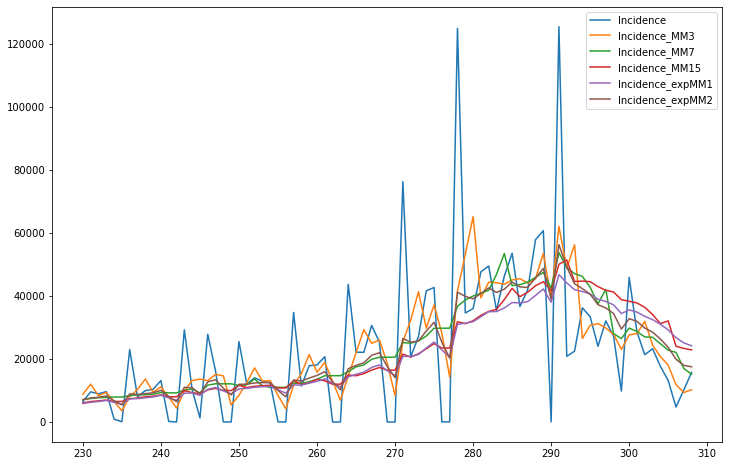

In [11]:
# TEST ON AVERAGING METHODS
colname = 'Confirmed'
currentdf = paysdf['France'][[colname]]
currentdf['Incidence'] = buildbrutIncidence(currentdf,colname)
currentdf.drop(colname, axis=1,inplace=True)
#currentdf
currentdf['Incidence_MM3'] = indicateurMM(currentdf,'Incidence',3)
currentdf['Incidence_MM7'] = indicateurMM(currentdf,'Incidence',7)
currentdf['Incidence_MM15'] = indicateurMM(currentdf,'Incidence',15) 
currentdf['Incidence_expMM1'] = indicateurExpMM(currentdf,'Incidence',0.1) 
currentdf['Incidence_expMM2'] = indicateurExpMM(currentdf,'Incidence',0.2) 
currentdf
currentdf.loc[230:308].plot(kind='line',figsize=(12,8))

## THIS STEP CONSTRUCT THE INPUT TABLES 
## FOR R-COMPUTING IN NOTEBOOK 2 and 3

In [12]:
# INCIDENCE BIG INPUT TABLE CONSTRUCTION 
# GET supplementary case from day to day
columnlists = ['Confirmed','Deaths','Recovered','Active']
MMAfactor = 7

for paysname in payslist:
    currentdf = paysdf[paysname]
    for colname in columnlists:
        brutname = colname+'_brutincidence'
        currentdf[colname+'_brutincidence'] = buildbrutIncidence(currentdf,colname)
        currentdf[colname+'_MMincidence'] = indicateurMM(currentdf,brutname,MMAfactor)
        currentdf[colname+'_eMMincidence'] = indicateurExpMM(currentdf,brutname,0.1)
    #
    filepath = datafolder+'/incidence_'+paysname+'_Table.csv'
    currentdf.to_csv(filepath,index=False)
    paysdf[paysname] = currentdf

<ipython-input-9-66cff6b61149>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['shift'] = newdf[columnName].shift(periods=1,fill_value=0)
<ipython-input-9-66cff6b61149>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['delta'] = newdf[columnName]-newdf['shift']
<ipython-input-9-66cff6b61149>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## VISUALISATION 

In [33]:
# VISUALISATION OF TABLES
# Uses a function to plot a dataframe and a slider to change which dataframe is plotted

def plotinccountry(countryval):
    """
        Plot raw data from API and brut_incidence computed on all categories in datacolumnlist
        
        Dependencies :  payslist dictionnary, datacolumnlist list
    """
    # define table to plot 
    countryname = payslist[countryval]
    cur_df = paysdf[countryname]
    # !!!! MAKE SURE YOUR DATETIME IS CONSIDERED AS SUCH BY PANDAS !!!!!
    cur_df['Date'] = pd.to_datetime(currentdf['Date'])

    # Create figure and plot space
    fig, ax1 = plt.subplots(figsize=(15, 8), dpi=80)
    # XSCALE
    ax1.set_xlabel('date')
    ax1.xaxis.set_major_locator(dt.MonthLocator())
    # YSCALE 1
    ax1.set_ylabel('cumulative cases')
    ax1.set_yscale('log')
    #ax1.set_ylim(bottom=100)
    ax1.grid(True)
    # YSCALE 2
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('incidence')  # we already handled the x-label with ax1
    
    # LOOP on DATA IN datacolumnlist
    for name in datacolumnlist:
        ax1.plot(cur_df['Date'], cur_df[name],label=name)#, color=colors[i%2]) # plt.plot(x, y, "y-", color=colors[i%2])
    ax1.legend()
    # LOOP ON INCIDENCE
    incidencelist = [x+'_brutincidence' for x in datacolumnlist]
    for name in incidencelist:
        ax2.plot(cur_df['Date'], cur_df[name])#, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

interact(plotinccountry,countryval=widgets.IntSlider(min=0,max=len(payslist)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='countryval', max=5), Output()), _dom_classes=('widget-in…

<function __main__.plotinccountry(countryval)>

In [32]:
def plotsmoothinccountry(countryval,dataval): 
    """
        Plot smoothed indicence data computed on dataframe on selected category in datacolumnlist
        
        Dependencies :  payslist dictionnary, datacolumnlist list
    """
    countryname = payslist[countryval]
    cur_df = paysdf[countryname]    
    datacolumnames = [datacolumnlist[dataval]+'_MMincidence',
                      datacolumnlist[dataval]+'_eMMincidence']
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(15, 15), dpi=80)
    # !!!! MAKE SURE YOUR DATETIME IS CONSIDERED AS SUCH BY PANDAS !!!!!
    cur_df['Date'] = pd.to_datetime(currentdf['Date'])
    
    # Create figure and plot space
    ax.title.set_text(datacolumnlist[dataval]+' '+countryname)
    # XSCALE
    ax.xaxis.set_major_locator(dt.MonthLocator())
    # YSCALE
    ax.set_ylabel('cumulative cases')
    ax.set_yscale('log')
    ax.grid(True)
    axbis = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axbis.set_ylabel('incidence',color='red')  # we already handled the x-label with ax1
    
    ax.plot(cur_df['Date'], cur_df[datacolumnlist[dataval]],label=datacolumnlist[dataval])
    axbis.plot(cur_df['Date'], cur_df[datacolumnames[0]],color='red',label=datacolumnames[0])
    axbis.plot(cur_df['Date'], cur_df[datacolumnames[1]],color='orange',label=datacolumnames[1])
    axbis.legend()
    ax.legend()
    plt.show()
    
interact(plotsmoothinccountry,countryval=widgets.IntSlider(min=0,max=len(payslist)-1,step=1,value=0),
         dataval=widgets.IntSlider(min=0,max=len(datacolumnlist)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='countryval', max=5), IntSlider(value=0, description='dat…

<function __main__.plotsmoothinccountry(countryval, dataval)>

In [24]:
def plotsmoothinccountry(countryval): 
    countryname = payslist[countryval]
    cur_df = paysdf[countryname]    

    # Create figure and plot space
    fig, axs = plt.subplots(4, 1,figsize=(15, 40), dpi=80)
    # !!!! MAKE SURE YOUR DATETIME IS CONSIDERED AS SUCH BY PANDAS !!!!!
    cur_df['Date'] = pd.to_datetime(currentdf['Date'])
    
    # Create figure and plot space
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=None)
    fig.suptitle('Cumulatives cases and corresponding incidence')

    for nameCat,ax in zip(datacolumnlist,axs.flat):
        ax.title.set_text(nameCat+' '+countryname)
        # XSCALE
        ax.xaxis.set_major_locator(dt.MonthLocator())
        # YSCALE
        ax.set_ylabel('cumulative cases')
        ax.set_yscale('log')
        ax.grid(True)
        
        axbis = ax.twinx()  # instantiate a second axes that shares the same x-axis
        axbis.set_ylabel('incidence',color='red')  # we already handled the x-label with ax1

        secondname = nameCat+'_MMincidence'
        thirdname = nameCat+'_eMMincidence'
        ax.plot(cur_df['Date'], cur_df[nameCat])
        axbis.plot(cur_df['Date'], cur_df[secondname],color='red')
        axbis.plot(cur_df['Date'], cur_df[thirdname],color='orange')

    plt.show()
    
interact(plotsmoothinccountry,countryval=widgets.IntSlider(min=0,max=len(payslist)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='countryval', max=5), Output()), _dom_classes=('widget-in…

<function __main__.plotsmoothinccountry(countryval)>